In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
from collections import defaultdict
from copy import deepcopy
import json
import os
import warnings
import glob
import re
from io import StringIO, BytesIO
from functools import partial
from typing import Tuple

import h5py
import k3d
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

In [4]:
import sys
sys.path.append('..')

In [5]:
from gcv_v20211_hw1.utils.plotting import display_depth_sharpness, display_sharpness
from gcv_v20211_hw1.utils.hdf5.dataset import Hdf5File, PreloadTypes
from gcv_v20211_hw1.utils.sharpf_io import WholeDepthMapIO, PointPatchPredictionsIO
from gcv_v20211_hw1.utils.camera_utils.camera_pose import camera_to_display, CameraPose

In [6]:
# from sharpf.utils.abc_utils.hdf5.dataset import Hdf5File, PreloadTypes
# import sharpf.data.datasets.sharpf_io as sharpf_io
# import sharpf.utils.abc_utils.hdf5.io_struct as io_struct
# from sharpf.utils.plotting import display_depth_sharpness
# from sharpf.utils.py_utils.config import load_func_from_config
# from sharpf.data.imaging import IMAGING_BY_TYPE


In [11]:
os.listdir('../scripts/validation/results/abc_0050_00500082_4cb4bf14428fe3832dd7ed78_000__ground_truth.hdf5')

['abc_0050_00500082_4cb4bf14428fe3832dd7ed78_000__ground_truth.hdf5',
 'abc_0050_00500082_4cb4bf14428fe3832dd7ed78_000__interpolated.hdf5',
 'abc_0050_00500149_54930d6f7740b03347d89a56_000__ground_truth.hdf5',
 'abc_0050_00500149_54930d6f7740b03347d89a56_000__interpolated.hdf5',
 'abc_0050_00500166_5894bbd701b2bb0fc88a6978_007__ground_truth.hdf5',
 'abc_0050_00500166_5894bbd701b2bb0fc88a6978_007__interpolated.hdf5',
 'abc_0050_00500348_fae0ecd8b3dc068d39f0d09c_000__ground_truth.hdf5',
 'abc_0050_00500348_fae0ecd8b3dc068d39f0d09c_000__interpolated.hdf5',
 'abc_0050_00500683_511f7debb63f164003339dec_000__ground_truth.hdf5',
 'abc_0050_00500683_511f7debb63f164003339dec_000__interpolated.hdf5']

In [8]:
# path_gr_tr = '/Users/artonson/tmp/gcv_hw1_data/abc_0050_00500149_54930d6f7740b03347d89a56_000.hdf5'
# path_pred = '/Users/artonson/tmp/gcv_hw1_data/abc_0050_00500149_54930d6f7740b03347d89a56_000__predictions.hdf5'
path_gr_tr = '../scripts/validation/med_res/abc_0050_00500082_4cb4bf14428fe3832dd7ed78_000.hdf5'
path_pred = '../scripts/validation/med_res/abc_0050_00500082_4cb4bf14428fe3832dd7ed78_000__predictions.hdf5'

ground_truth_dataset = Hdf5File(
    path_gr_tr,
    io=WholeDepthMapIO,
    preload=PreloadTypes.LAZY,
    labels='*')


predictions_dataset = Hdf5File(
    path_pred,
    io=WholeDepthMapIO,
    preload=PreloadTypes.LAZY,
    labels='*')

..\gcv_v20211_hw1\utils\hdf5\dataset.py:65: UserWarning: File C:\Users\dales\Skoltech\GCV\gcv_v2021.1_hw1\scripts\validation\med_res\abc_0050_00500082_4cb4bf14428fe3832dd7ed78_000__predictions.hdf5 is not compatible with Hdf5File I/O interface <class 'gcv_v20211_hw1.utils.hdf5.io_struct.HDF5IO'>
  self.filename, str(self.io.__class__)))


In [9]:
def distances_nobg(distances, image):
    distances_ = np.zeros_like(distances)
    distances_[np.nonzero(image)] = distances[np.nonzero(image)]
    return distances_

..\gcv_v20211_hw1\utils\plotting.py:132: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  depth_cmap.set_bad(color='black')
..\gcv_v20211_hw1\utils\plotting.py:148: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm_r"))
  sharpness_cmap.set_bad(color='black')


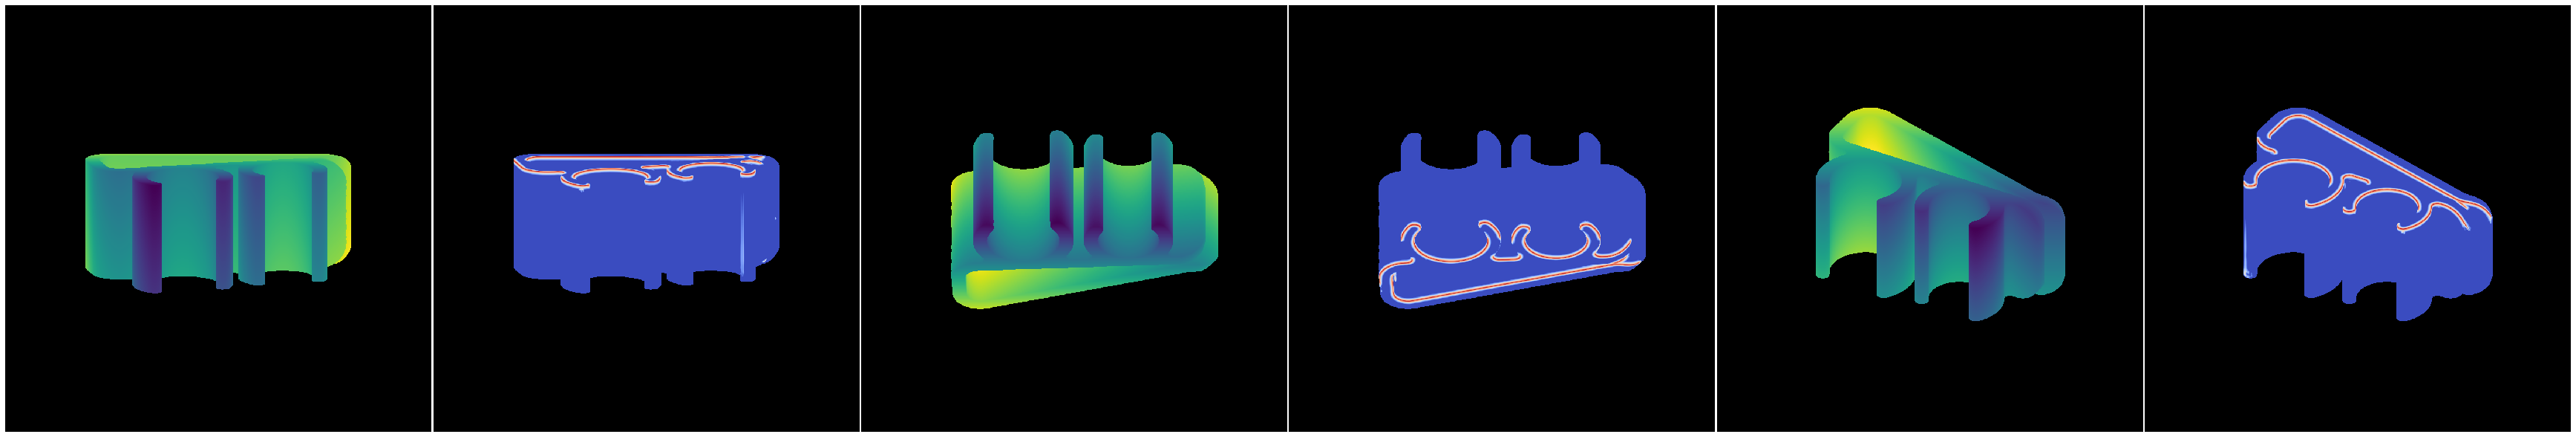

In [10]:
display_depth_sharpness(
    depth_images=[
        camera_to_display(ground_truth_dataset[0]['image']),
        camera_to_display(ground_truth_dataset[1]['image']),
        camera_to_display(ground_truth_dataset[2]['image']),
    ],
    sharpness_images=[
        camera_to_display(
            distances_nobg(predictions_dataset[0]['distances'], 
                           ground_truth_dataset[0]['image'])),
        camera_to_display(
            distances_nobg(predictions_dataset[1]['distances'], 
                           ground_truth_dataset[1]['image'])),
        camera_to_display(
            distances_nobg(predictions_dataset[2]['distances'], 
                           ground_truth_dataset[2]['image']))
    ],
    axes_size=(8, 8),
    ncols=3)

In [20]:
# input_gt = 'D:/Downloads/validation/high_res/abc_0050_00500166_5894bbd701b2bb0fc88a6978_007.hdf5'
# input_pred = 'D:/Downloads/validation/high_res/abc_0050_00500166_5894bbd701b2bb0fc88a6978_007__predictions.hdf5'
# output_dir = 'D:/Downloads/validation/results'
# os.listdir('D:/Downloads/validation/high_res')
# os.chdir('scripts')
# os.listdir()

In [21]:
# !python fuse_images.py -t validation\high_res\abc_0050_00500166_5894bbd701b2bb0fc88a6978_007.hdf5 -p validation\high_res\abc_0050_00500166_5894bbd701b2bb0fc88a6978_007__predictions.hdf5 -o validation\results\

In [31]:
fused_gt_path = '../scripts/validation/results/abc_0050_00500683_511f7debb63f164003339dec_000__ground_truth.hdf5'
fused_interp_path = '../scripts/validation/results/abc_0050_00500683_511f7debb63f164003339dec_000__interpolated.hdf5'


fused_gt_dataset = Hdf5File(
    #'/Users/artonson/tmp/gcv_hw1_data/abc_0050_00500149_54930d6f7740b03347d89a56_000__ground_truth.hdf5',
    fused_gt_path,
    io=PointPatchPredictionsIO,
    preload=PreloadTypes.LAZY,
    labels='*')

fused_pred_dataset = Hdf5File(
    #'/Users/artonson/tmp/gcv_hw1_data/abc_0050_00500149_54930d6f7740b03347d89a56_000__interpolated.hdf5',
    fused_interp_path,
    io=PointPatchPredictionsIO,
    preload=PreloadTypes.LAZY,
    labels='*')

In [32]:
display_sharpness(
    samples=fused_gt_dataset[0]['points'],
    samples_distances=fused_pred_dataset[0]['distances']
)

C:\Users\dales\Anaconda3\lib\site-packages\traittypes\traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()